# Module: Cosmic distances

> Rescaling the SEDs due to galactic distances. Will include cosmic redshifting and cosmic dimming effects. 

In [ ]:
#| default_exp cosmic_distance_effects

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from astropy.cosmology import *
from watercolor.ssp_interpolation import spec_ssp_lookup

from watercolor.load_sps_library import load_fsps_spectral_library, load_fsps_age_metallicity
from watercolor.load_sps_library import LIBRARY_FLUX_FILE, LIBRARY_WAVE_FILE, LIBRARY_AGE_FILE, LIBRARY_METAL_FILE
from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data
from watercolor.load_sim_stellar_catalog import GALS_FILE
from watercolor.load_sim_stellar_catalog import Z_SOLAR_PADOVA, H0

from watercolor.calculate_csp import calc_fluxes_for_galaxy

In [ ]:
#| hide

import matplotlib.pylab as plt

In [ ]:
#| hide

gal_tag, stellar_idx, metal_hydro, mass, age_hydro, x, y, z, vx, vy, vz = load_hacc_galaxy_data()

In [ ]:
#| hide

gal_id = 2
unique_gal_tag = np.unique(gal_tag)[gal_id]

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = calc_fluxes_for_galaxy(
    GALS_FILE, 
    unique_gal_tag,
    LIBRARY_FLUX_FILE,
    LIBRARY_WAVE_FILE,
    LIBRARY_AGE_FILE,
    LIBRARY_METAL_FILE)

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


(100.0, 1000.0)

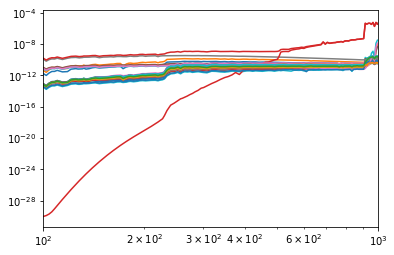

In [ ]:
#| hide

plt.figure()
plt.plot(spec_wave_ssp, spec_flux_ssp.T)
plt.plot(spec_wave_ssp, spec_csp)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2, 1e3)

In [ ]:
#| hide

def luminosity_solar(SED, redshift_in, wave):
    
    sed_Jy = SED
    sed_ergscm2A = sed_Jy*2.998e+18*1.0e-23/np.asarray(wave)/np.asarray(wave) #erg/s/cm2/A
    intSED = simps(sed_ergscm2A, wave) #erg/s/cm2
    # dd1  = alphaq_cosmo.luminosityDistance(redshift_in) #Mpc?
    dd1 = cosmo.luminosityDistance(redshift_in) #Mpc?

    dd1cm = dd1*3.086e+24 #cm
    fac = 4*np.pi*(dd1cm**2) #cm2
    lum = fac*intSED #erg/s
    lum_sol = lum/(3.826*1e33)
    
    return lum_sol

def observer_frame_wavelength(wavelength, 
                              redshift):
    obs_frame_wave = wavelength*(1 + redshift)
    return obs_frame_wave

In [ ]:
#| export

def spectrum_convert_from_ergscm2A(wave:np.array, # Input flux from 'erg/s/cm2/A'
                                    spec:np.array, # Wavelength 
                                    funit:str='Jy' # Output units
                                    ) -> np.array: # Converted flux to 'erg/s/cm2' or 'Jy'

    if funit=='erg/s/cm2/A' or funit==0:
        spec_new = spec
    elif funit=='erg/s/cm2' or funit==1:
        spec_new = np.asarray(spec)*np.asarray(wave)
    elif funit=='Jy' or funit==2:
        spec_new = np.asarray(spec)*np.asarray(wave)*np.asarray(wave)/1.0e-23/2.998e+18
    else:
        print ("The input funit is not recognized!")
        sys.exit()

    return spec_new


def spectrum_convert_from_uJy(wave:np.array, # Input flux from 'uJy'
                               spec:np.array, # Wavelength 
                               funit:str='Jy' # Output units
                               ) -> tuple: # Converted flux to 'erg/s/cm2' or 'erg/s/cm2/A'

    if funit=='Jy' or funit==0:
        spec_new = spec*1e6
    elif funit=='erg/s/cm2' or funit==1:
        spec_new = np.asarray(spec*1e6)/np.asarray(wave)
    elif funit=='erg/s/cm2/A' or funit==2:
        spec_new = np.asarray(spec*1e6)*(1.0e-23*2.998e+18)/(np.asarray(wave)*np.asarray(wave))
    else:
        print ("The input funit is not recognized!")
        sys.exit()

    return spec_new

In [ ]:
#| export

def spectrum_dimmed_and_redshifted(DL_Gpc:np.float64=0.0, # Luminosity distance (LD) in unit of Gpc.
                      cosmo:str='flat_LCDM', # Choice of Astropy cosmology models ['flat_LCDM', 'WMAP9', 'Planck15']
                      H0:np.float64=70.0, # Hubble constant at z=0.
                      Om0:np.float64=0.3, # Omega matter at z=0.
                      z:np.float64=0.01, # Redshift
                      wave:np.array=[], # Wavelength grids of the input spectrum.
                      spec: np.array=[] # Fluxes of the input spectrum.  
                      ) -> tuple: # wavelength, SED of the redshifted and dimmed spectrum

    if DL_Gpc > 0.0:
        DL = DL_Gpc
        DL = DL*3.08568e+27
    else:
        if cosmo=='flat_LCDM' or cosmo==0:
            cosmo1 = FlatLambdaCDM(H0=H0, Om0=Om0)
            DL = cosmo1.luminosity_distance(z)      # in unit of Mpc
        
        elif cosmo=='WMAP9' or cosmo==3:
            DL = WMAP9.luminosity_distance(z)
        
        elif cosmo=='Planck15' or cosmo==5:
            DL = Planck15.luminosity_distance(z)

        
        DL = DL.value/1.0e+3
        DL = DL*3.08568e+27

    redsh_wave = (1.0+z)*np.asarray(wave)
    cor = 1.0/12.56637061/DL/DL/(1.0+z)           # flux in L_solar cm^-2 A^-1
    cor = cor*3.826e+33                           # flux in erg s^-1 cm^-2 A^-1
    redsh_spec = cor*np.asarray(spec)

    return redsh_wave, redsh_spec

In [ ]:
#| hide

galaxy_star_catalog_file = '../watercolor/data/test_hacc_stellar_catalog/Gals_Z0.txt'
galaxy_tags, stellar_idx, metal_hydro, mass, age_hydro, _, _, _, _, _, _ = load_hacc_galaxy_data(galaxy_star_catalog_file)

In [ ]:
#| hide 

galaxy_number = 4
unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = calc_fluxes_for_galaxy(galaxy_star_catalog_file,
                                                                                              unique_galaxy_tag,
                                                                                              LIBRARY_FLUX_FILE,
                                                                                              LIBRARY_WAVE_FILE,
                                                                                              LIBRARY_AGE_FILE,
                                                                                              LIBRARY_METAL_FILE)

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


In [ ]:
# #| hide 

# spec_csp_ergscm2A = spectrum_convert_from_uJy(spec_wave_ssp, 
#                                 spec_csp,
#                                 funit='erg/s/cm2/A')

# redsh_wave, redsh_spec = spectrum_dimmed_and_redshifted(DL_Gpc=0.0,
#                                            cosmo='flat_LCDM',
#                                            H0=70.0,
#                                            Om0=0.3,
#                                            z=0.01,
#                                            wave=spec_wave_ssp,
#                                            spec=spec_csp_ergscm2A)

# redsh_spec = spectrum_convert_from_ergscm2A(redsh_wave,
#                                 redsh_spec,
#                                 funit='Jy')#*1e6

In [ ]:
#| export

def combine_redshift_and_dimming_effect(wave:np.array=[], # Wavelength grids of the input spectrum in Unit 
                                        spec:np.array=[], # # Fluxes of the input spectrum.  
                                        galaxy_redshift:np.float64=0.01 # Redshift of the galaxy
                                       ) ->tuple: # Output of wavelength and spectra
    
    spec_csp_ergscm2A = spectrum_convert_from_uJy(wave, 
                                spec,
                                funit='erg/s/cm2/A')

    redsh_wave, redsh_spec = spectrum_dimmed_and_redshifted(DL_Gpc=0.0,
                                               cosmo='flat_LCDM',
                                               H0=70.0,
                                               Om0=0.3,
                                               z=galaxy_redshift,
                                               wave=wave,
                                               spec=spec_csp_ergscm2A)

    redsh_spec = spectrum_convert_from_ergscm2A(redsh_wave,
                                    redsh_spec,
                                    funit='Jy')*1e6
    
    return redsh_wave, redsh_spec

In [ ]:
#| hide

redsh_wave, redsh_spec = combine_redshift_and_dimming_effect(spec_wave_ssp, spec_csp, 0.001)

<matplotlib.legend.Legend>

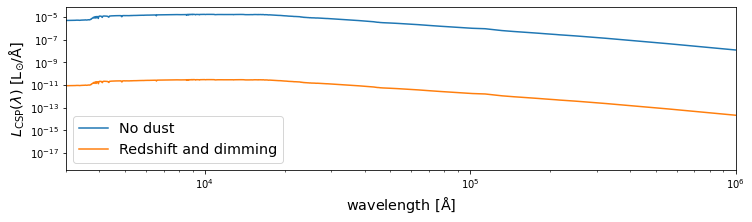

In [ ]:
#| hide 

f, a = plt.subplots(1, 1, figsize=(12, 3))
a.plot(spec_wave_ssp, spec_csp, label='No dust')
a.plot(redsh_wave, redsh_spec, label='Redshift and dimming')



# a.set_xlim(3e3, 1e4)
a.set_xlim(3e3, 1e6)

a.set_xscale('log')
a.set_yscale('log')

a.set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a.set_ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')
a.legend(fontsize='x-large')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()